# <center> **DSCI 100 Project: Predicting Usage of a Video Game Server**
## <center> **Predicting a Player's Subscription Status for Minecraft Newsletters**

## Introduction

A group of Computer Science students, led by Frank Wong, at UBC created a Minecraft server and recorded player demographics and play sessions data in two data frames.  The goal of their study was to learn how people play video games and determine ways to target recruitment efforts to have enough resources, such as software licences, and manage the number of users on their server.  One of their questions of interest was: "What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?"

This project report aims to answer a more specific question within their broad question.  The question we will explore is: Can age and gaming hours predict whether or not a player will subscribe to the Minecraft newsletter?

The dataset of player demographics (players.csv) will be used to answer this question and better understand the player characteristics that are predictive of subscribing to a gaming newsletter.  The following is a description of the dataset:

- Number of variables: 7
- Number of observations which represent players: 196
- Variables: name, gender, age, email, experience level, played hours and subscription status ("true" or "false")
- Variables of interest: age, played hours and 
- Overall Description: The data consists of MineCraft players of different ages with varying levels of experience in gaming and number of hours played.
- Positive label for the classification: "true" category
- Reasoning: We are interested in having players subscribe, and the broad question of the research group also focuses on subscribing to the newsletter.

A potential issue with the dataset is that the `subscribe` variable is logical type but should be a factor in order to treat it as a categorical variable for classification.  This column also contains many more 'true' than 'false' categories which may create an imbalance in the data and affect the K-nearest neighbours algorithm.  Note that the additional variables such as  `gender` or `experience` are not used as predictor variables in this analysis and therefore can be removed in the data wrangling step.

First, we load the necessary libraries to run the code, set the seed for reproducibility and read the file into R.

In [1]:
library(tidyverse) 
library(repr)
library(tidymodels) 
library(themis)
options(repr.matrix.max.rows = 6)
set.seed(1) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players_orig <- read_csv("players.csv")
players_orig

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [3]:
# Check the categories under the "subscribe" variable
players_orig |>
    distinct(subscribe)

# Determine the number of observations in each category of "True" and "False"
num_subscribe <- players_orig |>
    group_by(subscribe) |>
    summarize(count = n())
num_subscribe

# Calculate summary statistics for variables in the dataset
stats_players <- players_orig |>
    summarize(mean_age = mean(Age, na.rm = TRUE), min_age = min(Age, na.rm = TRUE), max_age = max(Age, na.rm = TRUE),
             mean_hours = mean(played_hours), min_hours = min(played_hours), max_hours = max(played_hours))
stats_players

subscribe
<lgl>
TRUE
FALSE


subscribe,count
<lgl>,<int>
FALSE,52
TRUE,144


mean_age,min_age,max_age,mean_hours,min_hours,max_hours
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20.52062,8,50,5.845918,0,223.1


In [4]:
stats_table <- data.frame(
    Statistic = c("Data Type", "Mean", "Min", "Max"),
    Age = c("Double", 20.52, 8, 50),
    Hours = c("Double", 5.85, 0, 233.1),
    Subscribe = c("Logical", NA, NA, NA), 
    Experience = c("Character", NA, NA, NA),
    Name = c("Character", NA, NA, NA), 
    Gender = c("Character", NA, NA, NA) 
)
stats_table

counts_table <- data.frame(
    Statistic = c("Data Type", "Count", "Count", "Count", "Count", "Count"),
    Name = c("Character", 196, "NA", "NA", "NA", "NA"),
    Subscribe = c("Logical", "True: 144", "False: 52", "NA", "NA", "NA"),
    Experience = c("Character", "Beginner: 35", "Amateur: 63", "Regular: 36", "Pro: 14", "Veteran: 48")
)
counts_table

Statistic,Age,Hours,Subscribe,Experience,Name,Gender
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Data Type,Double,Double,Logical,Character,Character,Character
Mean,20.52,5.85,NA,NA,NA,NA
Min,8,0,NA,NA,NA,NA
Max,50,233.1,NA,NA,NA,NA


Statistic,Name,Subscribe,Experience
<chr>,<chr>,<chr>,<chr>
Data Type,Character,Logical,Character
Count,196,True: 144,Beginner: 35
Count,NA,False: 52,Amateur: 63
Count,NA,NA,Regular: 36
Count,NA,NA,Pro: 14
Count,NA,NA,Veteran: 48


## Methods and Results

### Clean and Wrangle the Data
We will select the hashedEmail (to keep the identification of individual players), Age, played_hours and subscribe columns.  Since we consider `subscribe` as a categorical variable, we will convert it into a factor.  Overall, the dataset is tidy because each variable forms a column, each observation forms a row and each cell is a single value.

In [5]:
players <- players_orig |>
    mutate(subscribe = as_factor(subscribe)) |>
    select(hashedEmail, Age, played_hours, subscribe)
players

hashedEmail,Age,played_hours,subscribe
<chr>,<dbl>,<dbl>,<fct>
f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,9,30.3,TRUE
f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,17,3.8,TRUE
b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,17,0.0,FALSE
⋮,⋮,⋮,⋮
d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,17,0.0,FALSE
f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,17,2.3,FALSE
d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,NA,0.2,TRUE


### Create a Visualization for Exploratory Analysis

To explore the dataset, we create a scatter plot of the data with `Age` on the x-axis and `played_hours` on the y-axis before standardizing the variables, and we colour the observations based on subscription status. 

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


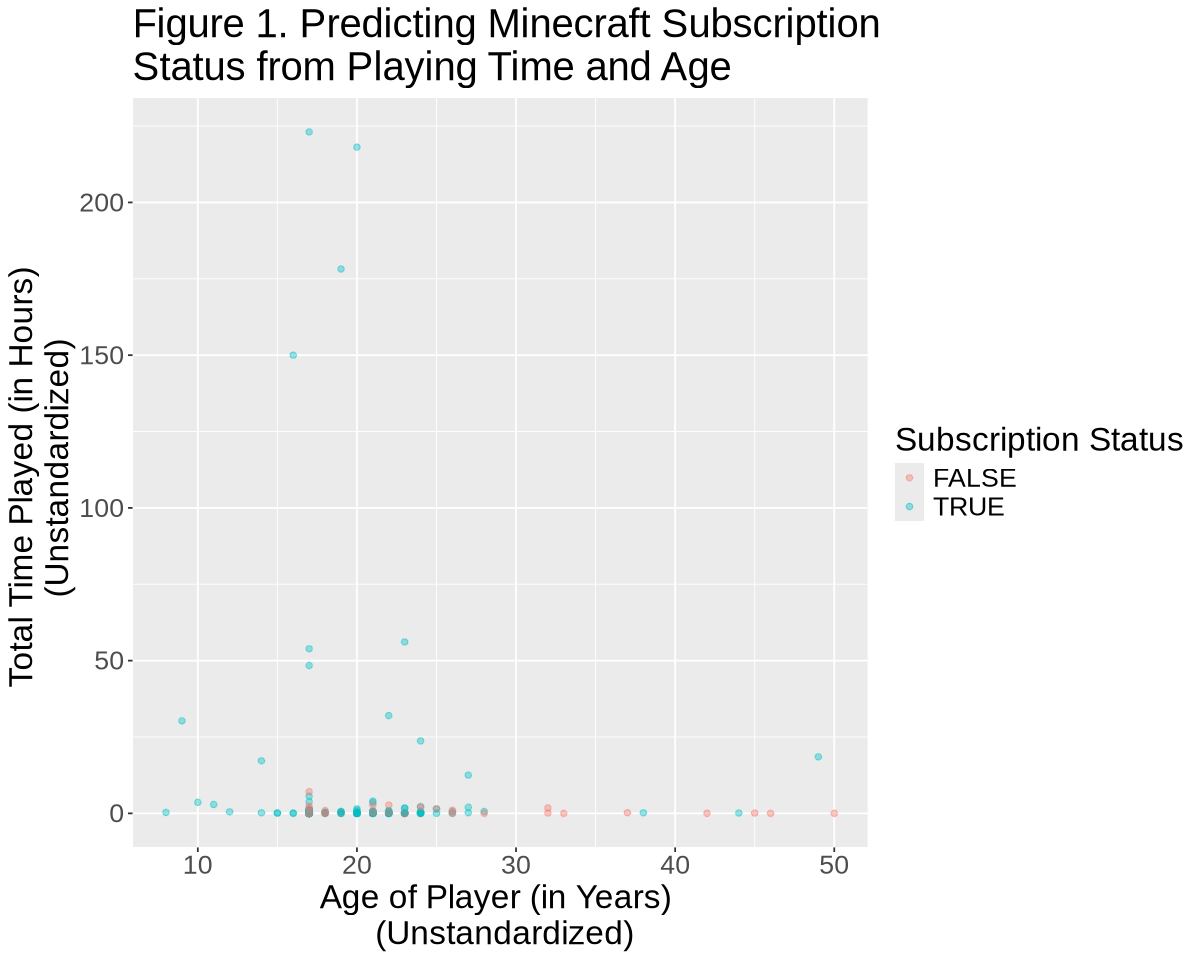

In [6]:
options(repr.plot.width = 10, repr.plot.height = 8)
players_scatter <- players |>
    ggplot(aes(x = Age, y = played_hours)) +
        geom_point(aes(color = subscribe), alpha = 0.4) +
        xlab("Age of Player (in Years) \n (Unstandardized)") +
        ylab("Total Time Played (in Hours) \n (Unstandardized)") +
        labs(color = "Subscription Status", title = "Figure 1. Predicting Minecraft Subscription \nStatus from Playing Time and Age") +
        theme(text = element_text(size = 20))
players_scatter

We can observe that many of the 196 observations are plotted very closely together, causing overplotting.  It is difficult to gain insight from the data and visually analyze the plot with K-nearest neighbours.  Since there are only 7 players that have played above 40 hours, we will cut off the top of the plot above 40 hours by limiting the y-axis but not removing any data points from the dataset.

We will double check that there are only 7 observations above 40 played hours.

In [16]:
players |> 
    filter(played_hours > 40) |>
    group_by(played_hours) |>
    summarize(count = n()) 

played_hours,count
<dbl>,<int>
48.4,1
53.9,1
56.1,1
⋮,⋮
178.2,1
218.1,1
223.1,1


Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_point()`).”


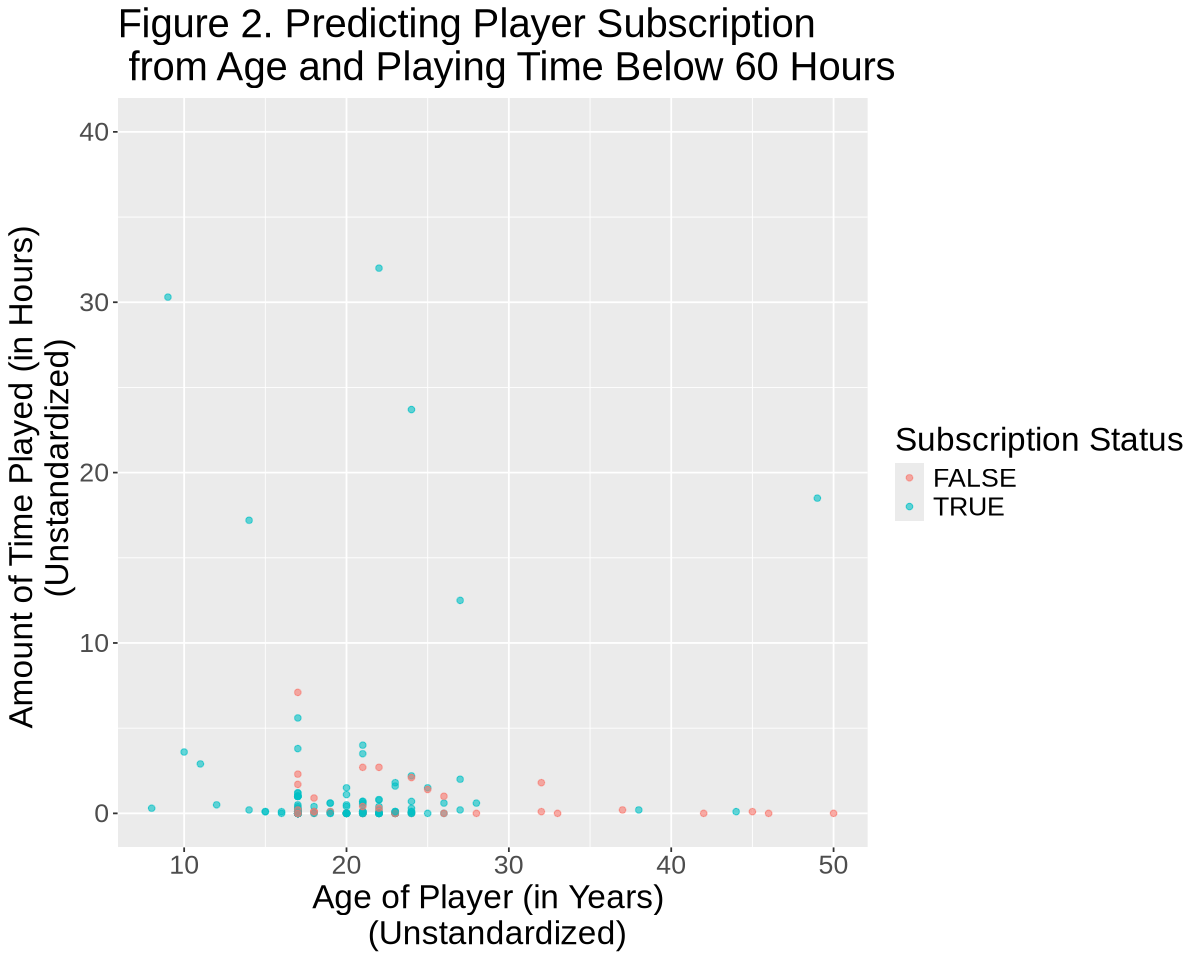

In [18]:
players_scatter_cut <- players |>
    ggplot(aes(x = Age, y = played_hours)) +
        geom_point(aes(color = subscribe), alpha = 0.6) +
        xlab("Age of Player (in Years) \n (Unstandardized)") +
        ylab("Amount of Time Played (in Hours) \n (Unstandardized)") +
        ylim(0, 40) +
        labs(color = "Subscription Status", title = "Figure 2. Predicting Player Subscription \n from Age and Playing Time Below 60 Hours") +
        theme(text = element_text(size = 20))
players_scatter_cut

Since there are only 3 observations above 20 hours, we will cut the plot above 20 hours.  In total, there are 10 observations above 20 hours.

Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`).”


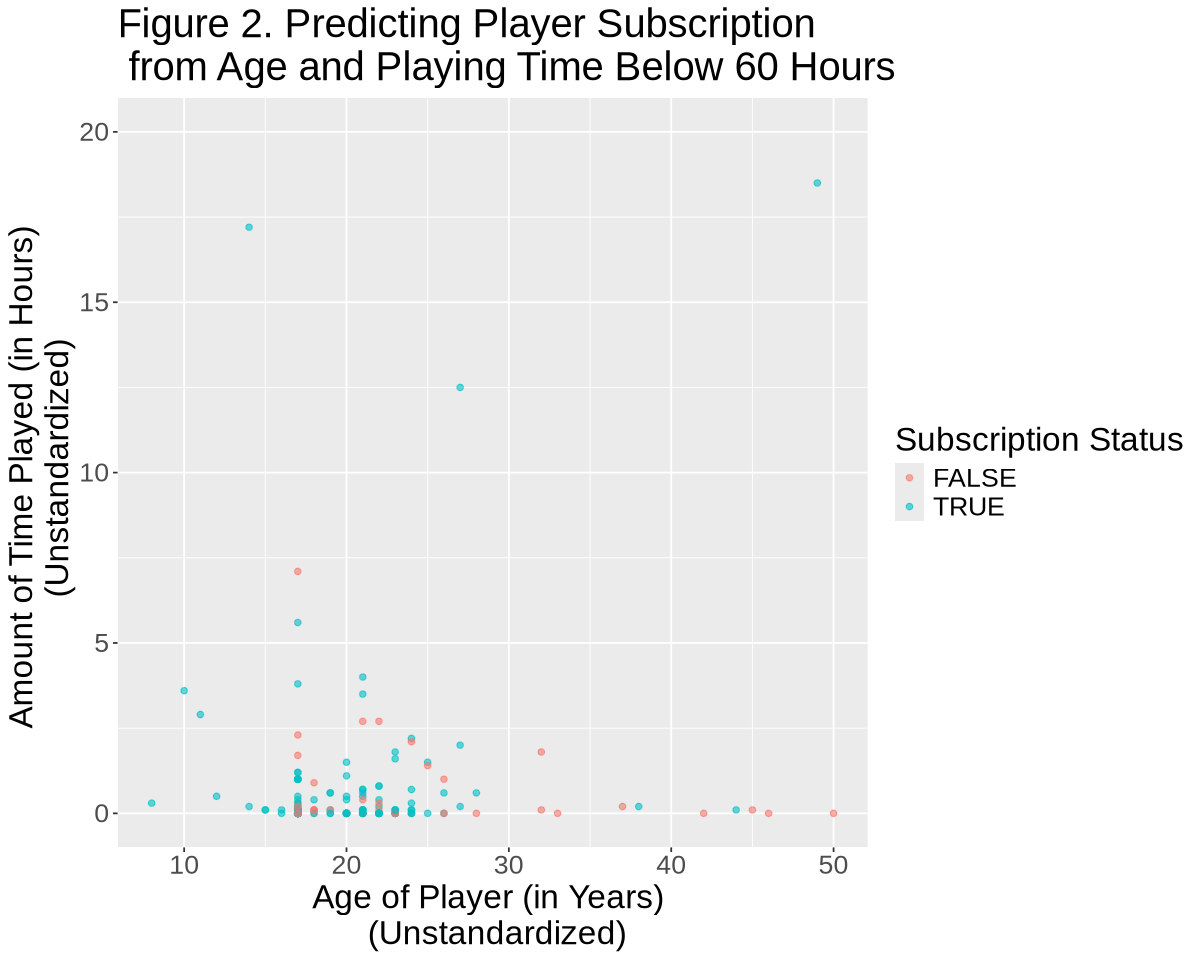

In [22]:
players_scatter_cut <- players |>
    ggplot(aes(x = Age, y = played_hours)) +
        geom_point(aes(color = subscribe), alpha = 0.6) +
        xlab("Age of Player (in Years) \n (Unstandardized)") +
        ylab("Amount of Time Played (in Hours) \n (Unstandardized)") +
        ylim(0, 20) +
        labs(color = "Subscription Status", title = "Figure 2. Predicting Player Subscription \n from Age and Playing Time Below 60 Hours") +
        theme(text = element_text(size = 20))
players_scatter_cut

The plot above has considerably more data points that are "true" than "false" as already observed in a table in the Introduction, so we will upsample the data to balance the categories of the response variable.  

In [9]:
ups_recipe <- recipe(subscribe ~ Age + played_hours, data = players) |>
    step_upsample(subscribe, over_ratio = 1, skip = FALSE) |>
    prep()
ups_recipe

ups_players <- bake(ups_recipe, players)



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Training information 

Training data contained 196 data points and 2 incomplete rows.



── Operations 

• Up-sampling based on: subscribe | Trained



The data analysis question asks to predict a categorical variable (`subscribe`) in the dataset of which there are two groups: "TRUE" and "FALSE".  Thus, it is a classification problem and the k-nearest neighbours classification algorithm will be used in this analysis.  K-nearest neighbours is a simple algorithm that does not have many requirements or assumptions for how the data should look.  It involves distance calculations between data points and assumes that nearby observations are more similar than farther ones.  Therefore, it is important to standardize the data so that the predictor variables have comparable scales.  

Potential limitations of using knn classification in this analysis is that it becomes slower with a larger training set, and it is sensitive to class imbalance in addition to standardized variables.  Other models have not been discussed in DSCI 100; thus, only this algorithm will be used.  

We will use functions from the tidymodels package to partition the players dataset into a training (75%) and testing (25%) set in order to evaluate the model on new data and not be required to collect more data.  The scales of the variables are uncomparable since the time played has a larger range than age, so we will center the mean to 0 and scale them to have a standard deviation of 1.

In [10]:
players_split <- initial_split(ups_players, prop = 0.75, strata = subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())
players_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Centering for: all_predictors()

• Scaling for: all_predictors()



We will create a knn model specification, perform 5-fold cross-validation and create an accuracy versus k plot to evaluate the model for each k and select the optimal k value. Note that the error below is not related to the output.

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 43 rows.
               ✖ Assigned data has 44 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 44 to size 43.

There were issues with some computations   A: x1

→ B | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 41 rows.
               ✖ Assigned data has 42 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 42 to size 41.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6461039,3,0.01974923,Preprocessor1_Model01
2,accuracy,binary,0.6612554,3,0.01129903,Preprocessor1_Model02
3,accuracy,binary,0.6078644,3,0.02046126,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,binary,0.5537518,3,0.05912675,Preprocessor1_Model08
9,accuracy,binary,0.5461760,3,0.02625311,Preprocessor1_Model09
10,accuracy,binary,0.5386003,3,0.03311248,Preprocessor1_Model10


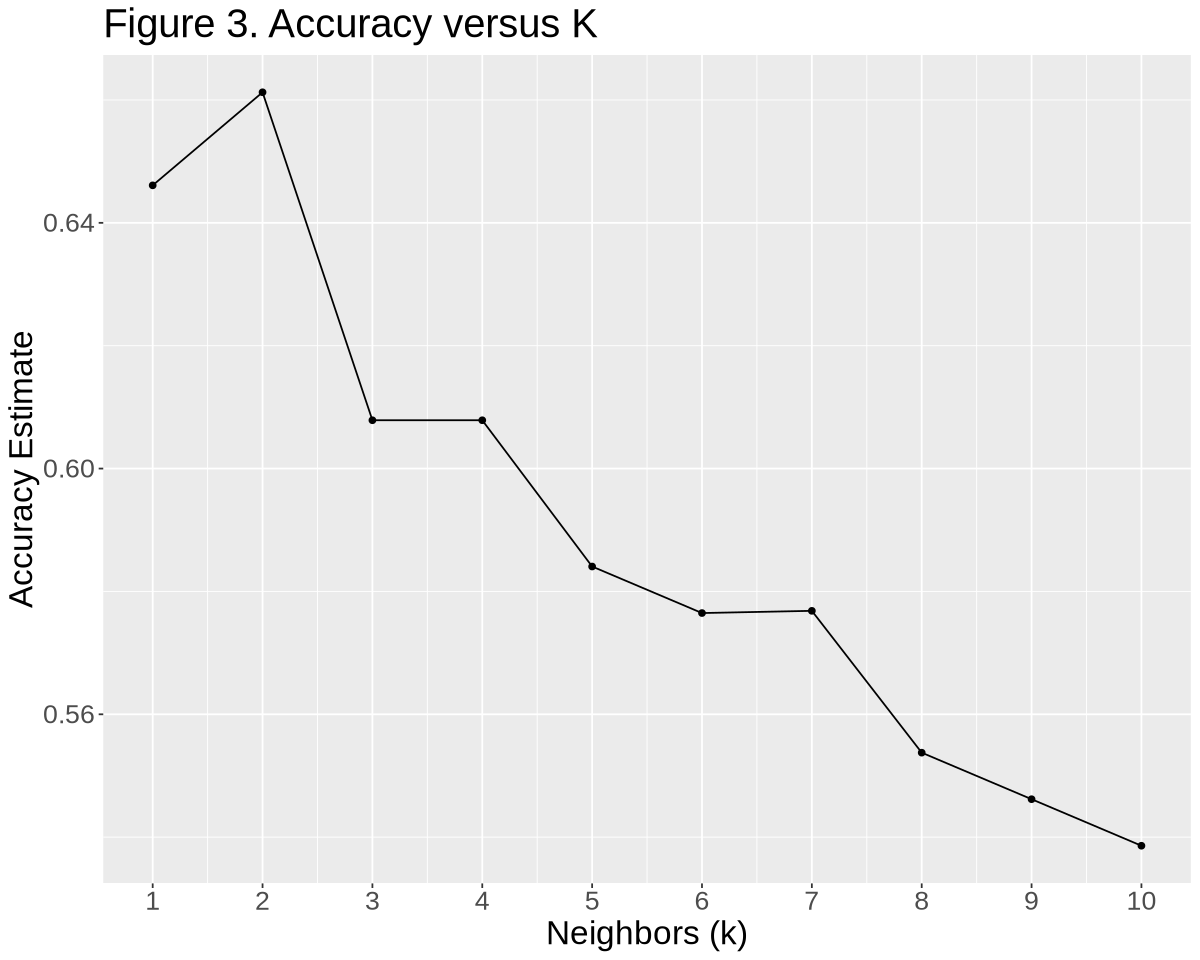

In [11]:
set.seed(1)

# Create a model specification
players_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Perform 5-fold cross-validation 
players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

# Create a tibble of k values
gridvals <- tibble(neighbors = seq(1, 10, by = 1))

# Create a workflow analysis and fit the model for each k value
players_knn_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_knn_spec) |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics()

# Filter for accuracies
accuracies <- players_knn_results |>
    filter(.metric == "accuracy")
accuracies

# Create a cross-validation plot of accuracies versus k
cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors (k)", y = "Accuracy Estimate", title = "Figure 3. Accuracy versus K") +
        scale_x_continuous(breaks = seq(1, 10, by = 1)) +  
        theme(text = element_text(size = 20))
cross_val_plot

According to the plot above, there is a peak at k = 2, but this value is small and could cause overfitting and make it unreliable to classify new data.  We will choose k = 3 because it has a high cross-validation accuracy estimate of approximately 61% which is close to the peak value.  Increasing or decreasing k to a nearby value does not change the accuracy by a large amount.  Moreover, choosing a value near k = 3 such as k = 4 could also be justified because the estimated accuracy of the classifier is close and different by only a small amount.  Even though there is a peak in accuracy at k = 3, it does not mean that the model is more accurate with the value because the values are estimates for the classifier's true accuracy.

We will retrain the model on the training data using k = 3.

In [12]:
# Retrain the model on the training data with k = 3
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification")

# Fit the model onto the training data
players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_training)

We will now predict on the test dataset using the final model and calculate the accuracy of the prediction.

In [13]:
players_predictions <- predict(players_fit, players_testing) |>
    bind_cols(players_testing)
players_predictions

players_metrics <- players_predictions |>
    metrics(truth = subscribe, estimate = .pred_class)
players_metrics

players_conf_mat <- players_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
players_conf_mat

.pred_class,Age,played_hours,subscribe
<fct>,<dbl>,<dbl>,<fct>
FALSE,28,0,FALSE
TRUE,22,0,FALSE
FALSE,26,1,FALSE
⋮,⋮,⋮,⋮
TRUE,19,0.6,TRUE
TRUE,21,0.1,TRUE
FALSE,17,0.0,TRUE


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7083333
kap,binary,0.4166667


          Truth
Prediction FALSE TRUE
     FALSE    33   18
     TRUE      3   18

Precision = correct positive predictions / total positive predictions 

In [14]:
precision <- 18/21 
precision

[1] 0.8571429

Recall = correct positive predictions / total positive observations 

In [15]:
recall <- 18/36
recall

[1] 0.5

## Discussion

The results from Figure 3 show that the optimal k value for k-nearest neighbours classification is 3.  The accuracy of the model is 70.8%, the precision is 85.7% and the recall is 50.0%.  This means that the model can predict the subscription of players 70.8% correctly and we can be confident that the predictions it makes for subscribed players are correct 85.7% of the time.  However, we can only expect the model to identify only half of the subscribed players correctly.  

While the accuracy and precision are fairly high, the recall is quite low.  This result may be expected as many of the data points lie close to one another by overplotting and many players play a similar number of hours regardless of their age, making it difficult to predict the class of the observation using distance calculations.  In this context, recall may be most important because we want to identify all the players who subscribed and ensure that we have a good idea of how many players have subscribed.  This can help the research group increase marketing efforts to have other players subscribe.     

In conclusion, the model performs fairly well in terms of accuracy and precision; however, it should be improved in recall to identify the players who have subscribed more accurately.  Age and played hours can help predict whether a player has subscribed to the gaming newsletter or not.  A more advanced classification method such as decision trees may work well with imbalanced data and help improve the recall for player subscription. Future trials can also try using logarithm scaling of the hours played variable to improve the visual plot.  Future questions can address which variables would be the best predictors for subscription status of a player and include more predictors such as experience.